In [32]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [222]:
trans_dataset_list = ['0', '20']
models = ['rtdetr-l-coco-torch', 'yolov8m-world-torch']
results = {}

for t in trans_dataset_list:
    results[t] = {}
    for model in models:
        with open(f'evaluation/transdata_{t}_n25_{model}_results.json', 'r') as f:
            results[t][model] = json.load(f)
        

In [179]:
results['0']['rtdetr-l-coco-torch'].keys()

dict_keys(['og_dataset', 'trans_dataset', 'model_name', 'affected_dict', 'affected_perc', 'threshold_list', 'affected_scores', 'og_metrics', 'trans_metrics', 'overall_og_mean_metrics', 'overall_trans_mean_metrics', 'trans_obj_metrics', 'overall_obj_metrics', 'matching_scores', 'overall_mean_matching_score', 'overall_mean_affected_matching_score'])

In [176]:
type(results['0']['rtdetr-l-coco-torch']['overall_trans_mean_metrics'])

dict

In [180]:
type(results['0']['rtdetr-l-coco-torch']['og_dataset'])

str

In [198]:
def get_df(overlap_result, metric_name):
    # makes a df wit the result for a single dataset (e.g. trans_0), for a single metric
    data = {}
    index_needed=False
    for model in overlap_result:
        data[model] = {}
        print(overlap_result[model][metric_name])
        if type(overlap_result[model][metric_name]) == dict:
            for additional_metric in overlap_result[model][metric_name]:
                data[model][additional_metric] = overlap_result[model][metric_name][additional_metric]
        else:
            index_needed=True
            data[model] = overlap_result[model][metric_name]
    print(data)
    if index_needed:
        df = pd.DataFrame(data, index=[metric_name])
    else:
        df = pd.DataFrame(data)
    return df

In [129]:
def plot_difference(df1, df2, metric_name):
    if df1.shape != df2.shape:
        raise ValueError("DataFrames must have the same shape to calculate differences.")

    # Calculate the difference between the two DataFrames
    difference_df = df1 - df2

    # Create the bar plot for the differences
    difference_df.plot(kind='bar', figsize=(10, 6))

    # Customize the plot
    plt.xlabel('Evaluation Index')
    plt.ylabel(f'Difference in {metric_name}')
    plt.title(f'Difference in {metric_name} Between Two DataFrames')
    plt.legend(title='Model')
    
    # Show the plot
    plt.show()

    return difference_df

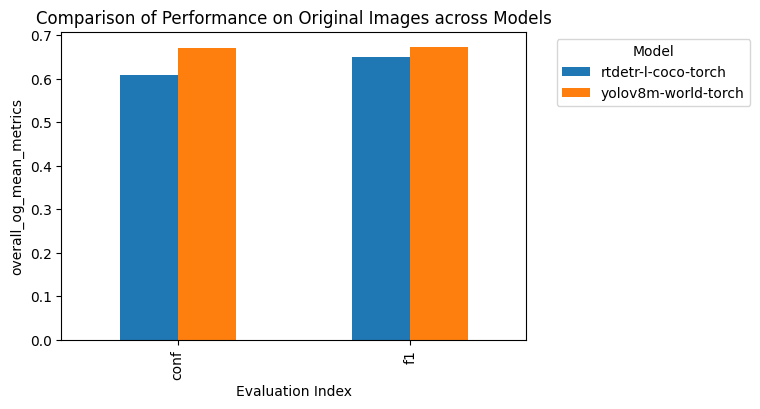

In [85]:
def plot_bar_perf(metric_name, overlap_result):
    data = get_df(overlap_result, metric_name)
    data.plot(kind='bar', figsize=(6, 4))

    # Customize the plot
    plt.xlabel('Evaluation Index')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of Performance on Original Images across Models')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Show the plot
    plt.show()

plot_bar_perf('overall_og_mean_metrics', results['0'], )

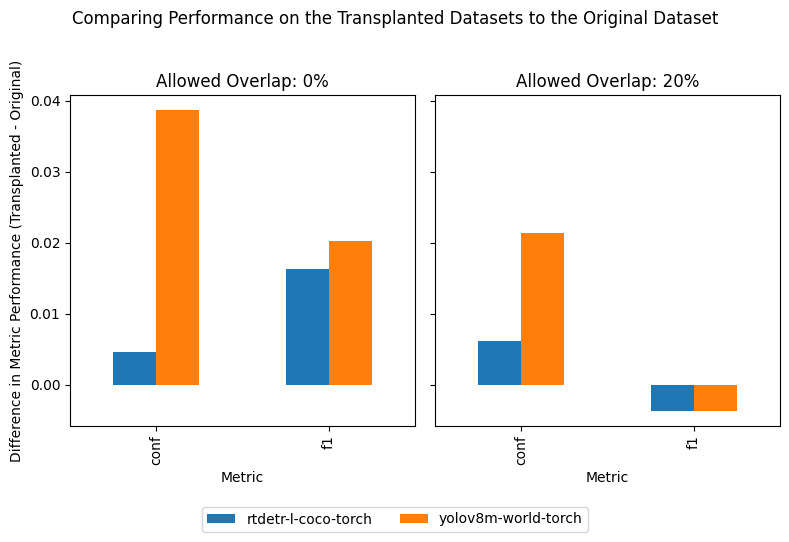

In [182]:

def plot_difference_mult(metric_name, df_pairs, titles):
    n = len(df_pairs)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(8, 5), sharey=True)

    combined_handles, combined_labels = None, None
    for i, (df1, df2) in enumerate(df_pairs):
        if df1.shape != df2.shape:
            raise ValueError("DataFrames must have the same shape to calculate differences.")

        # Calculate the difference between the two DataFrames
        difference_df = df2 - df1

        # Plot the DataFrame on the respective subplot
        ax = difference_df.plot(kind='bar', ax=axes[i], legend=False)
        
        # Customize the subplot
        axes[i].set_title(f'Allowed Overlap: {titles[i]}%')
        axes[i].set_xlabel('Metric')
        if i == 0:
            axes[i].set_ylabel(f'Difference in {metric_name} (Transplanted - Original)')
        
        # Collect legend handles and labels from the last subplot
        if i == 0:
            combined_handles, combined_labels = ax.get_legend_handles_labels()
    fig.suptitle("Comparing Performance on the Transplanted Datasets to the Original Dataset")
    # Set a single legend for the entire figure
    fig.legend(combined_handles, combined_labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=n)

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    plt.show()

og_perf = get_df(results['0'], 'overall_og_mean_metrics')
trans_0_perf = get_df(results['0'], 'overall_trans_mean_metrics')
trans_20_perf = get_df(results['20'], 'overall_trans_mean_metrics')
# trans_100_perf = get_df(results['0'], 'overall_trans_mean_metrics')
df_pairs = [(og_perf, trans_0_perf), (og_perf, trans_20_perf)]
# print(df_pairs)

plot_difference_mult('Metric Performance', df_pairs, ['0', '20'])

In [155]:
def get_df_transposed(overlap_result, metric_name):
    # makes a df wit the result for a single dataset (e.g. trans_0), for a single metric
    data = {}
    for additional_metric in overlap_result['yolov8m-world-torch'][metric_name]:
        data[additional_metric] = {}
        for model in overlap_result:
            data[additional_metric][model] = overlap_result[model][metric_name]
            data[additional_metric][model] = overlap_result[model][metric_name][additional_metric]
    df = pd.DataFrame(data)
    print(df)
    return df

                     0.3       0.5       0.7      0.95      0.99
rtdetr-l-coco-torch  0.0  0.227119  0.454237  0.908475  0.959322
yolov8m-world-torch  0.0  0.016949  0.393220  0.745763  0.976271
                          0.3       0.5       0.7      0.95      0.99
rtdetr-l-coco-torch  0.025424  0.191737  0.463983  0.824153  0.884534
yolov8m-world-torch  0.037076  0.184322  0.459746  0.723517  0.942797


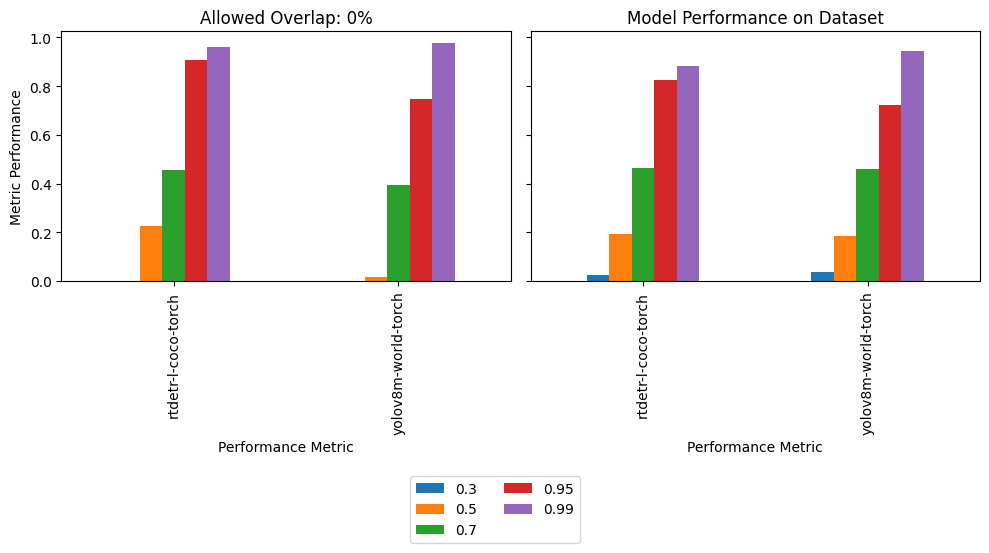

In [187]:
def plot_bar_perf_mult(metric_name, overlap_results):
    fig, axes = plt.subplots(nrows=1, ncols=len(overlap_results), figsize=(10, 5), sharey=True)
    
    combined_data = {}
    for i, overlap in enumerate(overlap_results): # This needs to be over the [0.3, 0.5, 0.95, 0.99]
        overlap_result_index = overlap
        overlap_result = overlap_results[overlap]
        df = get_df_transposed(overlap_result, metric_name)
        df.plot(kind='bar', ax=axes[i], legend=False)
        
        # Customize the subplot
        axes[i].set_title(f'Allowed Overlap: {overlap_result_index}%')
        axes[i].set_xlabel('Performance Metric')
        if i == 0:
            axes[i].set_ylabel('Metric Performance')
        
        # Collect legend handles and labels
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()
    
    # Set a single legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(overlap_results))

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.title(f"Model Performance on Dataset")
    
    # Show the plot
    plt.show()

plot_bar_perf_mult('affected_perc', results)

0.794526625021128
0.8112932069804384
{'rtdetr-l-coco-torch': 0.794526625021128, 'yolov8m-world-torch': 0.8112932069804384}
                             rtdetr-l-coco-torch  yolov8m-world-torch
overall_mean_matching_score             0.794527             0.811293
0.8113565952228695
0.810643291102622
{'rtdetr-l-coco-torch': 0.8113565952228695, 'yolov8m-world-torch': 0.810643291102622}
                             rtdetr-l-coco-torch  yolov8m-world-torch
overall_mean_matching_score             0.811357             0.810643


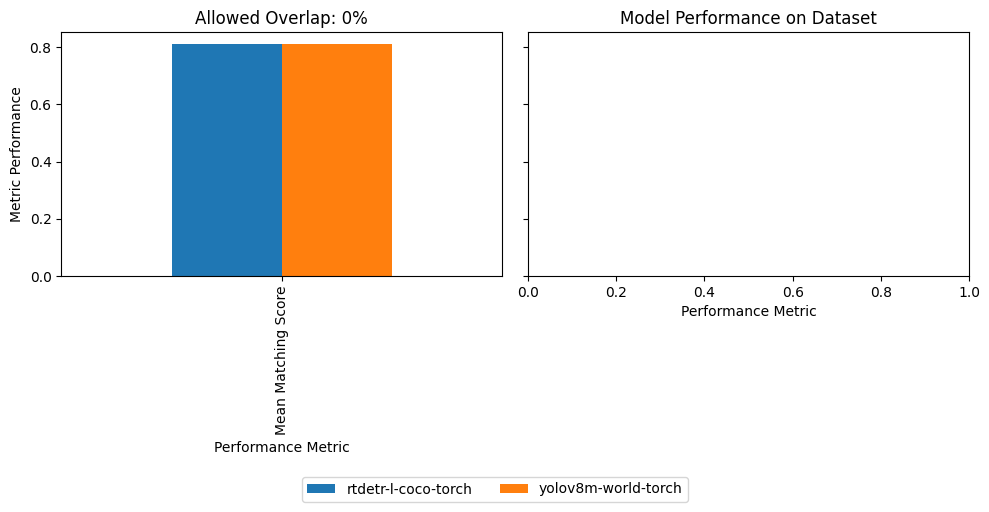

In [201]:
def plot_bar_perf_mult(metric_name, overlap_results, metric_display_name='Mean Matching Score'):
    fig, axes = plt.subplots(nrows=1, ncols=len(overlap_results), figsize=(10, 5), sharey=True)
    
    combined_data = {}
    for i, overlap in enumerate(overlap_results):
        overlap_result_index = overlap
        overlap_result = overlap_results[overlap]
        df = get_df(overlap_result, metric_name)
        df = df.rename(index={metric_name: metric_display_name})
        df.plot(kind='bar', ax=axes[0], legend=False)
        
        # Customize the subplot
        axes[i].set_title(f'Allowed Overlap: {overlap_result_index}%')
        axes[i].set_xlabel('Performance Metric')
        if i == 0:
            axes[i].set_ylabel('Metric Performance')
        
        # Collect legend handles and labels
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()
    
    # Set a single legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(overlap_results))

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.title(f"Model Performance on Dataset")
    
    # Show the plot
    plt.show()
    
plot_bar_perf_mult('overall_mean_matching_score', results)

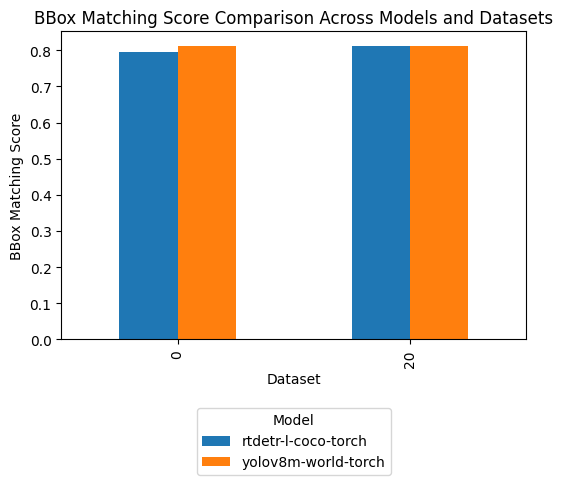

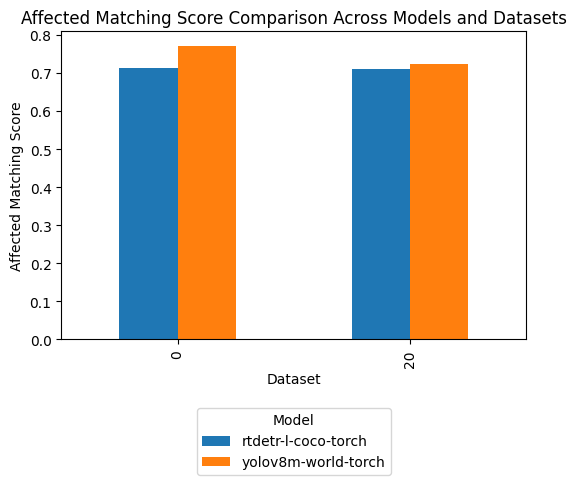

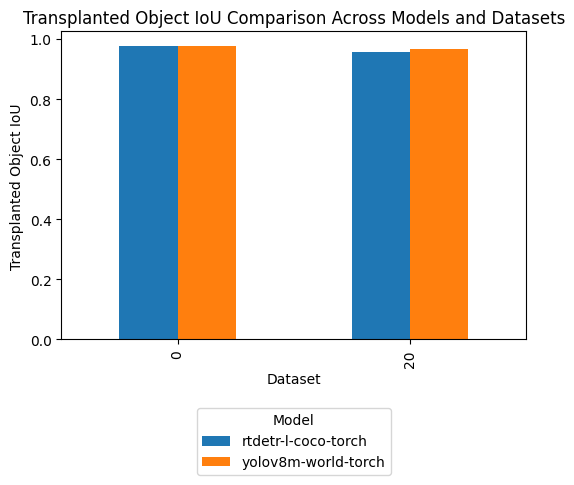

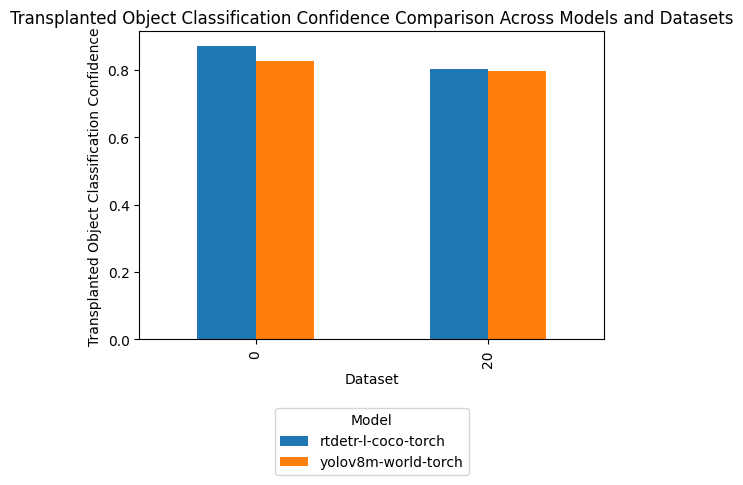

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(results, metric, addition=None):
    data = []
    for dataset, models in results.items():
        for model, metrics in models.items():
            if addition is None:
                data.append([dataset, model, metrics[metric]])
            else:
                data.append([dataset, model, metrics[metric][addition]])
    
    df = pd.DataFrame(data, columns=['Dataset', 'Model', 'Metric'])
    return df

def plot_grouped_bar(df, metric_name):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Pivot data for plotting
    df_pivot = df.pivot(index='Dataset', columns='Model', values='Metric')
    
    # Plot grouped bar chart
    df_pivot.plot(kind='bar', ax=ax)
    
    # Customize the plot
    ax.set_xlabel('Dataset')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Comparison Across Models and Datasets')
    ax.legend(title='Model', loc='upper center', bbox_to_anchor=(.5, -0.2))
    # ax.legend(title='Model', loc='upper right', bbox_to_anchor=(1.45, 1))
    # Show the plot
    plt.show()

# Example usage:
# Assuming your results dictionary is already defined
df_metrics = extract_metrics(results, 'overall_mean_matching_score')
plot_grouped_bar(df_metrics, "BBox Matching Score")

df_metrics = extract_metrics(results, 'overall_mean_affected_matching_score')
plot_grouped_bar(df_metrics, "Affected Matching Score")

df_metrics = extract_metrics(results, 'overall_obj_metrics', 'iou')
plot_grouped_bar(df_metrics, "Transplanted Object IoU")

df_metrics = extract_metrics(results, 'overall_obj_metrics', 'cc')
plot_grouped_bar(df_metrics, "Transplanted Object Classification Confidence")

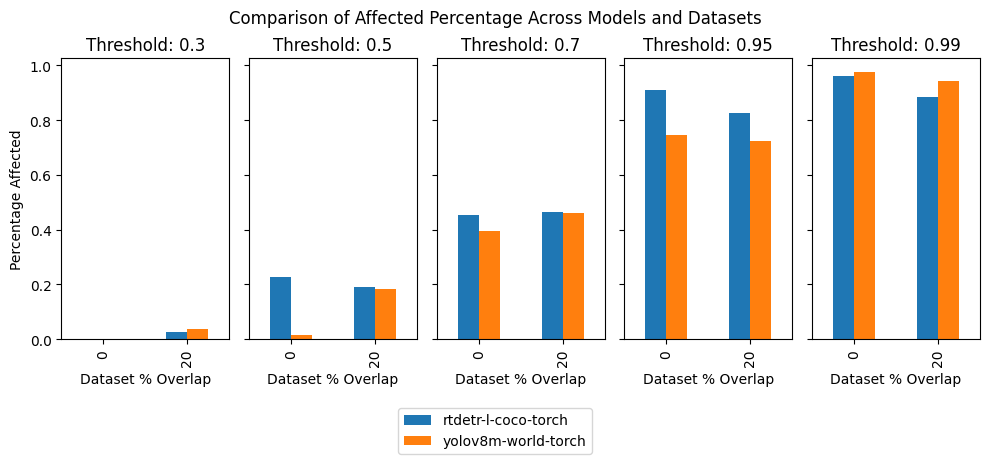

In [171]:
def plot_affected_perc_mult(results):
    affected_values = ["0.3", "0.5", "0.7", "0.95", "0.99"]
    fig, axes = plt.subplots(nrows=1, ncols=len(affected_values), figsize=(10, 4), sharey=True)

    for i, affected_val in enumerate(affected_values):
        combined_data = {}
        for dataset in results:
            combined_data[dataset] = {}
            for model in results[dataset]:
                combined_data[dataset][model] = results[dataset][model]["affected_perc"][affected_val]

        # Convert to DataFrame
        df = pd.DataFrame(combined_data)

        # Transpose to switch axes; index should be models
        df = df.T

        # Plot DataFrame
        df.plot(kind='bar', ax=axes[i], legend=False)

        # Customize subplot
        axes[i].set_title(f'Threshold: {affected_val}')
        axes[i].set_xlabel('Dataset % Overlap')
        if i == 0:
            axes[i].set_ylabel('Percentage Affected')

        # Collect legend handles and labels
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()

    # Set a single legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=1)

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("Comparison of Affected Percentage Across Models and Datasets")

    # Show the plot
    plt.show()

plot_affected_perc_mult(results)

In [216]:
# 'rtdetr-l-coco-torch', 'yolov8m-world-torch'
acc_results = {
    '0': {
        'rtdetr-l-coco-torch': {
            'overall_obj_metrics': {
                'acc' : 0.8711864406779661
            }
        },
        'yolov8m-world-torch': {
            'overall_obj_metrics': {
                'acc' :  0.8271186440677966
            }
        }
    },
    '20': {
        'rtdetr-l-coco-torch': {
            'overall_obj_metrics': {
                'acc' : 0.801906779661017
            }
        },
        'yolov8m-world-torch': {
            'overall_obj_metrics': {
                'acc' :  0.7966101694915254
            }
        }
    }
}

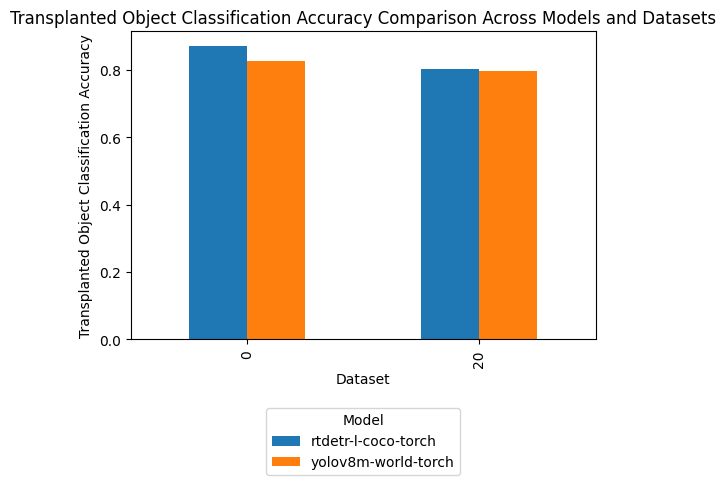

In [239]:
df_metrics = extract_metrics(acc_results, 'overall_obj_metrics', 'acc')
plot_grouped_bar(df_metrics, "Transplanted Object Classification Accuracy")